In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision import models

import albumentations as A
from fastprogress import progress_bar, master_bar

%matplotlib inline

In [2]:
path = '../data/'

In [3]:
tr = pd.read_csv(path + 'train.csv')
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [4]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

801


,ImageId_ClassId,EncodedPixels
0,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
1,0025bde0c.jpg_4,315139 8 315395 15 315651 16 315906 17 316162 ...
2,002af848d.jpg_4,290800 6 291055 13 291311 15 291566 18 291822 ...
3,0030401a5.jpg_4,186833 1 187089 3 187344 6 187600 7 187855 10 ...
4,008621629.jpg_4,215548 3 215798 9 216051 12 216306 13 216560 1...


### Decode mask

In [5]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 255
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

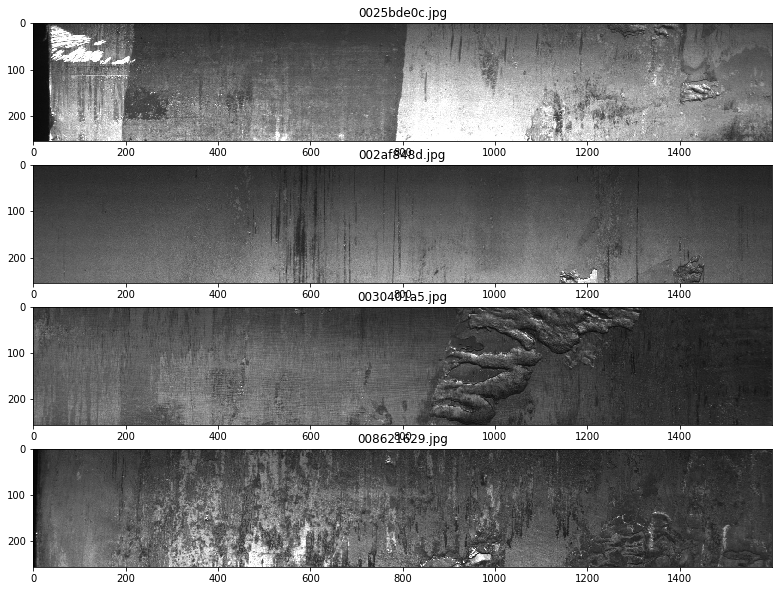

In [6]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

In [7]:
def load_image(image_path: str) -> np.ndarray:
    """
    openCV image loader.
    Always transform image to RGB.
    :param image_path: path object to image
    :return: numpy array
    """
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def tensor_from_rgb_image(image: np.ndarray) -> torch.Tensor:
    image = np.moveaxis(image, -1, 0)
    image = np.ascontiguousarray(image)
    image = torch.from_numpy(image)
    return image


class ImageDataCV2(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = load_image(self.data_path + fn).astype(np.float32) / 255.0
        
        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            res = self.transform(image=img, mask=mask)
            img, mask = res['image'], res['mask']
            return img, mask
        else: 
            img = self.transform(image=img)['image']
            return tensor_from_rgb_image(img)
        

class ImageDataPIL(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

In [8]:
import albumentations.torch as AT

pil_data = ImageDataPIL(df=df_train, transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))
cv2_data = ImageDataCV2(df=df_train, transform=A.Compose([A.Resize(256, 256), AT.ToTensor()]))

In [9]:
def plt_channel(channel):
    img = channel.numpy()
    print(img.min(), img.max())
    plt.imshow(img)

0.0 1.0


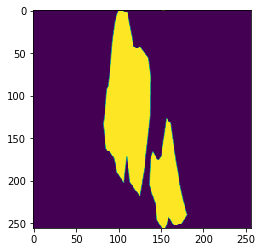

In [10]:
plt_channel(pil_data[0][1][0])

0.0 1.0


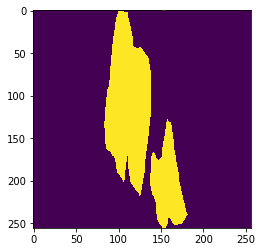

In [11]:
plt_channel(cv2_data[0][1][0])

In [12]:
np.array_equal(pil_data[0][1][0] > 0, cv2_data[0][1][0] > 0)

False

In [13]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

### Training

In [14]:
model = UNet(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)
train_loader = DataLoader(dataset=pil_data, batch_size=16, num_workers=6)

In [15]:
epochs_range = list(range(5))
epochs_bar = master_bar(epochs_range)

for epoch in epochs_bar:
    
    train_loss = .0
    model.train()
    
    for data, target in progress_bar(train_loader, parent=epochs_bar):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epochs_bar.child.comment = f'loss - {loss.item():.6f}'
        train_loss += loss.item() / len(train_loader)
    
    epochs_bar.write(f'train loss - {train_loss:.6f}')

In [16]:
model = UNet(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = 0.001, momentum=0.9)
train_loader = DataLoader(dataset=cv2_data, batch_size=16, num_workers=6)

In [17]:
epochs_range = list(range(5))
epochs_bar = master_bar(epochs_range)

for epoch in epochs_bar:
    
    train_loss = .0
    model.train()
    
    for data, target in progress_bar(train_loader, parent=epochs_bar):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)  
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epochs_bar.child.comment = f'loss - {loss.item():.6f}'
        train_loss += loss.item() / len(train_loader)
    
    epochs_bar.write(f'train loss - {train_loss:.6f}')

In [29]:
from albumentations.core.serialization import to_dict